# Task 3: You decide (Quality)

• Predict wine quality (red and white datasets merged).

• Use two different algorithms.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.svm import SVC
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load the red and white wine datasets
df_red = pd.read_csv('/home/hjoaquim/Documents/applied-ai/wine-analysis/data/red_wine.csv')
df_white = pd.read_csv('/home/hjoaquim/Documents/applied-ai/wine-analysis/data/white_wine.csv')

# Remove rows with missing values from both datasets
df_red.dropna(inplace=True)
df_white.dropna(inplace=True)

# Merge the datasets
wine_data = pd.concat([df_red, df_white], ignore_index=True)
display(wine_data.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,5.8,1.01,0.66,2.0,0.039,15.0,88.0,0.99357,3.66,0.60,11.5,6
1,7.8,0.82,0.29,4.3,0.083,21.0,64.0,0.99642,3.16,0.53,9.4,5
2,7.1,0.66,0.00,3.9,0.086,17.0,45.0,0.99760,3.46,0.54,9.5,5
3,6.1,0.56,0.00,2.2,0.079,6.0,9.0,0.99480,3.59,0.54,11.5,6
4,7.8,0.55,0.35,2.2,0.074,21.0,66.0,0.99740,3.25,0.56,9.2,5


In [3]:
# Since we want to predict 'color', separate the features and the target
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.43028229255774164
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00       389
           6       0.43      1.00      0.60       503
           7       0.00      0.00      0.00       189
           8       0.00      0.00      0.00        39

    accuracy                           0.43      1169
   macro avg       0.07      0.17      0.10      1169
weighted avg       0.19      0.43      0.26      1169



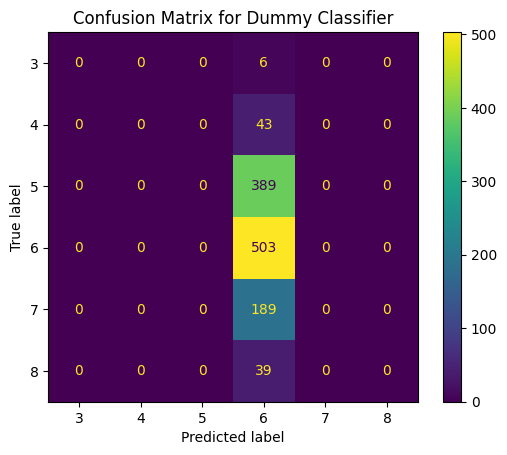

In [4]:
# Initialize a baseline algorithm using DummyClassifier
# The strategy "most_frequent" will always predict the most frequent class label in the training dataset
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)

# Predict with DummyClassifier
y_pred_oneR = dummy_clf.predict(X_test)

# Evaluate the baseline classifier
accuracy_score_dummy = dummy_clf.score(X_test, y_test)
print(f"Accuracy: {accuracy_score_dummy}")
print(classification_report(y_test, y_pred_oneR, zero_division=0.0))
ConfusionMatrixDisplay.from_estimator(dummy_clf, X_test, y_test)
plt.title("Confusion Matrix for Dummy Classifier")
plt.show()

Accuracy: 0.5517536355859709
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.02      0.05        43
           5       0.62      0.60      0.61       389
           6       0.52      0.75      0.61       503
           7       0.52      0.18      0.27       189
           8       0.00      0.00      0.00        39

    accuracy                           0.55      1169
   macro avg       0.44      0.26      0.26      1169
weighted avg       0.55      0.55      0.51      1169



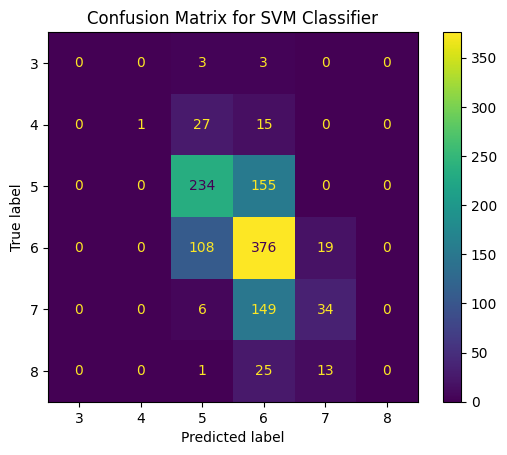

In [5]:
# SVM
# 1. Feature scaling -  SVMs are sensitive to the scale of the data, so it's a good practice to standardize the features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train the model
svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf.fit(X_train_scaled, y_train)

# 3. Evaluate the model
y_pred_svm = svm_clf.predict(X_test_scaled)
accuracy_score_svm = svm_clf.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy_score_svm}")
print(classification_report(y_test, y_pred_svm, zero_division=0.0))
ConfusionMatrixDisplay.from_estimator(svm_clf, X_test_scaled, y_test)
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

In [6]:
# Neural Network
#0. Re-map the quality labels
# PyTorch, when using CrossEntropyLoss, the target labels are expected to be in the range [0, C-1] where C is the number of classes.
quality_mapping = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6}
y_train_mapped = y_train.replace(quality_mapping)
y_test_mapped = y_test.replace(quality_mapping)

#1. Prepare the data
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

X_train_tensor = torch.tensor(X_train_array.astype(np.float32))
y_train_tensor = torch.tensor(y_train_mapped.values)
X_test_tensor = torch.tensor(X_test_array.astype(np.float32))
y_test_tensor = torch.tensor(y_test_mapped.values)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#2. Build NN
class WineQualityNet(nn.Module):
    def __init__(self):
        super(WineQualityNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(np.unique(y_train)))  # Output size = number of quality scores

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#3. Train NN
model = WineQualityNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):  # Number of epochs
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

#4. Evaluate NN
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')

/home/hjoaquim/miniconda3/envs/wine-analysis/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Accuracy: 0.5141
